In [1]:
import matplotlib.pyplot as plt
from IPython.display import HTML,display
import os
import pandas as pd
import seaborn as sns

CARD_FACTORY_DATA_DIR = os.path.join(os.environ.get('APPDATA'), 'Godot', 'app_userdata', 'Card Factory', 'data')
GAME_RESULTS_PATH = os.path.join(CARD_FACTORY_DATA_DIR, 'GameAnalysis_Results.csv')
PLAYER_CARD_RESULTS_PATH = os.path.join(CARD_FACTORY_DATA_DIR, 'GameAnalysis_PlayerCardPerformance.csv')
ENEMY_CARD_RESULTS_PATH = os.path.join(CARD_FACTORY_DATA_DIR, 'GameAnalysis_EnemyCardPerformance.csv')

# Game Balance Analysis

Using the GameSimulator component to analyze the balance between auto-generated AI and heuristic-based player win rates.

Also check to see win/lose rates for when the player or enemy puts certain card types into play to check card stat balance.

(0.0, 1.0)

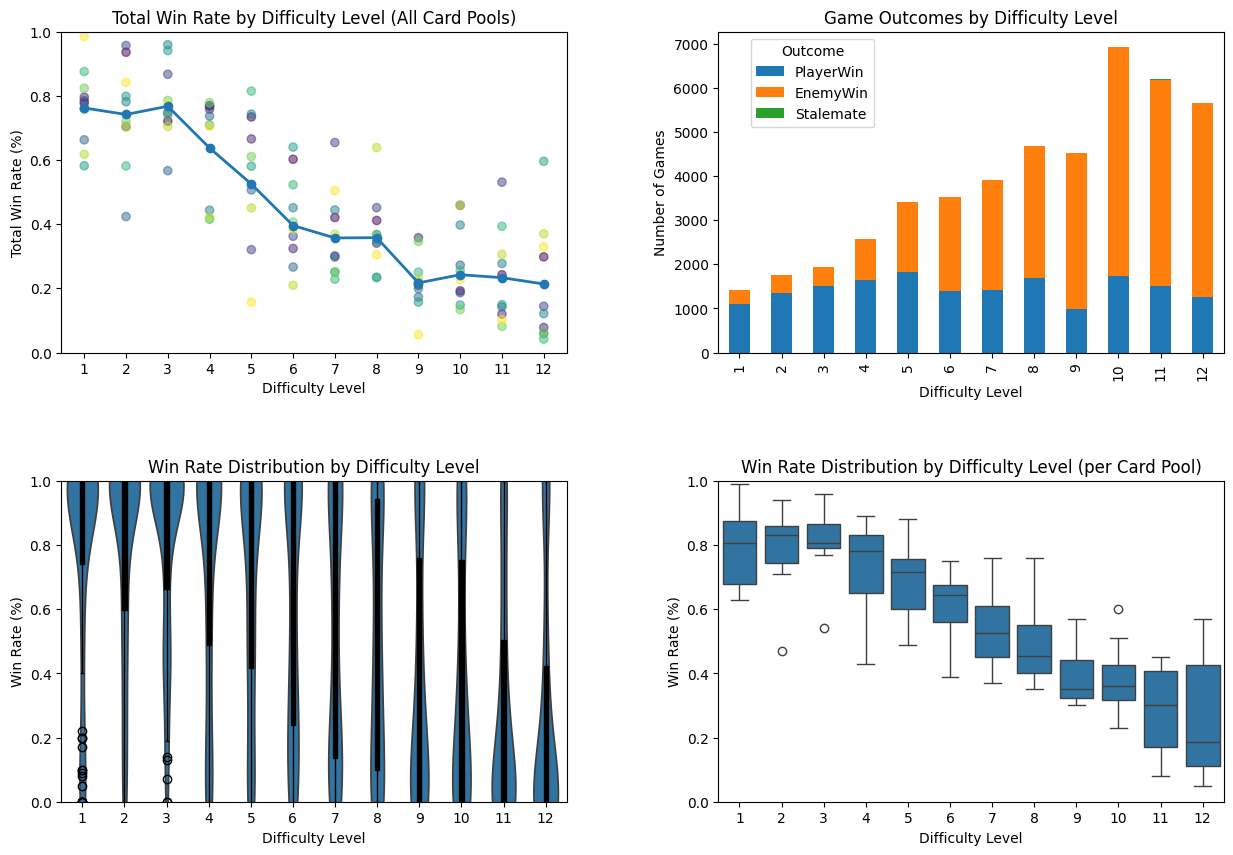

In [2]:
df = pd.read_csv(GAME_RESULTS_PATH, skipinitialspace=True)

cardpool_level_summary = df.groupby(['Pool', 'Level']).agg({
        'TotalGames': 'sum',
        'WinRate': 'mean',
        'PlayerWin': 'sum',
        'EnemyWin': 'sum',
        'Stalemate': 'sum',
        'MaxTurnsReached': 'sum'
    }).round(2).reset_index()

level_summary = df.groupby('Level').agg({
        'TotalGames': 'sum',
        'WinRate': 'mean',
        'PlayerWin': 'sum',
        'EnemyWin': 'sum',
        'Stalemate': 'sum',
        'MaxTurnsReached': 'sum'
    }).round(2)

plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Total Win Rate by Level
plt.subplot(2, 2, 1)
plt.title('Total Win Rate by Difficulty Level (All Card Pools)')
plt.scatter(cardpool_level_summary['Level'], cardpool_level_summary['PlayerWin'] / cardpool_level_summary['TotalGames'], c=cardpool_level_summary['Pool'], cmap='viridis', alpha=0.5)
plt.plot(level_summary.index, level_summary['PlayerWin'] / level_summary['TotalGames'], marker='o', linewidth=2)
plt.xlabel('Difficulty Level')
plt.xticks(level_summary.index)
plt.ylabel('Total Win Rate (%)')
plt.ylim(0, 1)

# 2. Game Outcomes Stacked Bar Chart
plt.subplot(2, 2, 2)
level_summary[['PlayerWin', 'EnemyWin', 'Stalemate']].plot(
    kind='bar', 
    stacked=True, 
    ax=plt.gca()
)
plt.title('Game Outcomes by Difficulty Level')
plt.xlabel('Difficulty Level')
plt.ylabel('Number of Games')
plt.legend(title='Outcome', bbox_to_anchor=(0.05, 1), loc='upper left')

# 4. Win Rate Distribution for all games
plt.subplot(2, 2, 3)
sns.violinplot(x='Level', y='WinRate', data=df, inner=None)
sns.boxplot(x='Level', y='WinRate', data=df, width=0.1, color='black')
plt.title('Win Rate Distribution by Difficulty Level')
plt.xlabel('Difficulty Level')
plt.ylabel('Win Rate (%)')
plt.ylim(0, 1)

# 4. Win Rate Distribution between Card Pools
plt.subplot(2, 2, 4)
sns.boxplot(x='Level', y='WinRate', data=cardpool_level_summary)
plt.title('Win Rate Distribution by Difficulty Level (per Card Pool)')
plt.xlabel('Difficulty Level')
plt.ylabel('Win Rate (%)')
plt.ylim(0, 1)

# Card Analysis

In [17]:
def create_win_rate_grid_by_factor(df, factor_name, factor_values):
    atk_max = df['Attack'].max()
    hp_max = df['Health'].max()
    mean_win_rate = df['Win Count'].sum() / df['Played Count'].sum()

    display(HTML(f'<h1>Win Rate by "{factor_name}" (Mean Win Rate: {mean_win_rate:.2%})</h1>'))
    for factor_value in factor_values:
        display(HTML(f'<h2>{factor_name}: {factor_value}</h2>'))
        factor_win_rate_grid = pd.DataFrame(index=pd.Index(range(0, atk_max), name="Attack"), columns=pd.Index(range(0, hp_max), name="Health"))
        for atk in range(0, atk_max):   
            for hp in range(0, hp_max):
                cards = df[
                    (df['Attack'] == atk) &
                    (df['Health'] == hp) &
                    (df[factor_name].str.contains(factor_value, case=False, na=False))]

                if len(cards) == 0:
                    factor_win_rate_grid.at[atk, hp] = { 'played': 0, 'win': 0 }
                else:
                    played_count = cards['Played Count'].sum()
                    win_count = cards['Win Count'].sum()
                    factor_win_rate_grid.at[atk, hp] = { 'played': played_count, 'win': win_count }

        def str_format(val):
            if val['played'] == 0:
                return '-'
            else:
                return f"{val['win'] / val['played']:.2%} [{val['played']}]"
        
        def cell_format(val):
            if val['played'] == 0:
                return 'background-color: none'
            
            win_rate = val['win'] / val['played']
            delta_win_rate = win_rate - mean_win_rate
            if delta_win_rate < -0.05:
                return f'background-color: rgba(255, 0, 0, {abs(delta_win_rate)})'
            elif delta_win_rate > 0.05:
                return f'background-color: rgba(0, 255, 0, {abs(delta_win_rate)})'
            return 'background-color: none'
            
        display(factor_win_rate_grid.style.format(str_format).map(cell_format))


def visualize_win_rate_by_factor(df, factor_name):
    plt.figure(figsize=(15, 5))
    plt.xlabel(factor_name)
    plt.ylabel('Win Rate (%)')
    plt.title(f'Win Rate Distribution by {factor_name}')
    sns.violinplot(x=factor_name, y='Win Rate', data=df, inner='box')
    plt.show()


# Player Cards

Statistical analysis of the balance on player cards.

In [4]:
df = pd.read_csv(PLAYER_CARD_RESULTS_PATH, skipinitialspace=True)
df['Abilities'] = df['Abilities'].fillna('None')
df['Win Rate'] = 100.0 * df['Win Count'] / df['Played Count']

top_10_cards = df.sort_values('Win Rate', ascending=False).head(10)
bottom_10_cards = df.sort_values('Win Rate').head(10)

display(HTML('<h2>Top 10 Player Cards by Win Rate</h2>'))
display(HTML(top_10_cards[['Rarity', 'BloodCost', 'Attack', 'Health', 'Abilities', 'Played Count', 'Win Count', 'Lose Count', 'Win Rate']].to_html(index=False)))

display(HTML('<h2>Bottom 10 Player Cards by Win Rate</h2>'))
display(HTML(bottom_10_cards[['Rarity',  'BloodCost', 'Attack', 'Health', 'Abilities', 'Played Count', 'Win Count', 'Lose Count', 'Win Rate']].to_html(index=False)))

Rarity,BloodCost,Attack,Health,Abilities,Played Count,Win Count,Lose Count,Win Rate
Rare,One,4,1,None,4,4,0,100.000000
Rare,Three,2,5,Agile-Lethal,49,49,0,100.000000
Rare,Three,5,2,Agile,89,89,0,100.000000
Rare,One,2,1,Agile,471,460,11,97.664544
Common,Three,5,2,None,48,46,2,95.833333
Uncommon,Three,4,2,Agile,122,114,5,93.442623
Rare,Two,3,2,Agile,75,62,13,82.666667
Uncommon,Three,3,5,Lethal,22,18,4,81.818182
Rare,Three,3,8,Guard,53,42,11,79.245283
Uncommon,Three,3,4,Agile,191,149,40,78.010471


Rarity,BloodCost,Attack,Health,Abilities,Played Count,Win Count,Lose Count,Win Rate
Uncommon,Three,5,4,None,26,0,24,0.000000
Rare,Two,3,4,Guard,79,2,77,2.531646
Uncommon,Two,1,5,Lethal,267,8,247,2.996255
Uncommon,Two,1,4,Agile,713,50,655,7.012623
Uncommon,One,0,2,Lethal,1466,114,1330,7.776262
Rare,Two,1,5,Guard-Lethal,135,11,124,8.148148
Common,Three,2,6,Guard,75,8,63,10.666667
Uncommon,One,0,1,Agile,753,89,637,11.819389
Uncommon,Three,2,5,Guard-Lethal,8,1,7,12.500000
Common,One,0,1,Guard,6104,977,5006,16.005898


In [18]:
create_win_rate_grid_by_factor(df, 'Rarity', ['Common', 'Uncommon', 'Rare'])
create_win_rate_grid_by_factor(df, 'BloodCost', ['One', 'Two', 'Three'])
create_win_rate_grid_by_factor(df, 'Abilities', ['None', 'Agile', 'Guard', 'Lethal'])

Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,64.54% [10074],73.76% [3243],58.09% [14759],-,76.47% [323],-,-
1,-,73.54% [30532],76.26% [40431],78.20% [6696],89.54% [2180],57.36% [326],-,-
2,-,86.78% [7208],83.87% [831],89.75% [11317],87.37% [3025],87.70% [5758],100.00% [37],-
3,-,86.67% [120],87.83% [961],88.52% [5209],98.38% [1669],100.00% [13],94.23% [849],-
4,-,-,95.93% [344],-,97.88% [1370],-,-,-
5,-,-,100.00% [227],-,100.00% [41],-,-,-


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,65.51% [6030],73.76% [3243],56.36% [5470],-,76.47% [323],-,-
1,-,74.48% [19188],-,77.61% [5927],89.54% [2180],57.36% [326],-,-
2,-,83.06% [2745],83.87% [831],95.59% [2107],84.59% [2239],-,-,-
3,-,-,89.29% [794],96.98% [563],95.96% [421],100.00% [13],-,-
4,-,-,98.61% [144],-,94.92% [59],-,-,-
5,-,-,100.00% [158],-,100.00% [41],-,-,-


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,68.51% [3045],67.75% [5324],60.89% [1309],-,-,-,-
1,-,77.99% [1808],84.30% [5866],83.62% [6525],91.16% [1176],89.16% [1052],-,-
2,-,86.86% [1416],82.57% [1130],93.49% [1629],80.51% [1216],100.00% [53],-,-
3,-,80.85% [564],91.71% [712],95.97% [819],97.17% [247],100.00% [85],100.00% [43],-
4,-,100.00% [124],-,100.00% [28],100.00% [125],99.59% [242],100.00% [12],-
5,-,-,100.00% [42],-,100.00% [110],-,100.00% [71],-


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,64.54% [10074],73.76% [3243],58.09% [14759],-,76.47% [323],-,-
1,-,74.33% [6170],76.53% [41501],78.12% [6976],91.16% [1176],-,-,-
2,-,84.27% [3426],82.57% [1130],88.53% [889],-,-,-,-
3,-,80.85% [564],-,91.62% [179],-,-,-,-
4,-,100.00% [124],-,-,-,-,-,-
5,-,-,-,-,-,-,-,-


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,-,-,-,-,-,-,-
1,-,71.40% [6017],83.78% [4796],85.55% [4866],89.54% [2180],81.64% [1378],-,-
2,-,89.07% [4463],83.87% [831],90.12% [11544],83.15% [3455],87.28% [5566],-,-
3,-,86.67% [120],90.44% [1506],88.11% [4978],96.12% [618],-,-,-
4,-,-,100.00% [117],-,-,-,-,-
5,-,-,-,-,-,-,-,-


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,-,-,-,-,-,-,-
1,-,-,-,-,-,-,-,-
2,-,-,-,95.52% [513],95.29% [786],100.00% [245],100.00% [37],-
3,-,-,80.84% [167],97.24% [871],99.23% [1298],100.00% [98],94.51% [892],-
4,-,-,93.83% [227],100.00% [28],98.06% [1495],99.59% [242],100.00% [12],-
5,-,-,100.00% [269],-,100.00% [151],-,100.00% [71],-


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,62.19% [59865],-,59.10% [9289],-,76.47% [323],-,-
1,-,73.67% [23672],75.25% [35635],75.39% [5779],-,-,-,-
2,-,83.42% [3480],-,84.99% [2685],-,87.20% [5531],-,-
3,-,86.67% [120],-,87.23% [4669],95.42% [371],-,94.23% [849],-
4,-,100.00% [124],100.00% [117],-,98.02% [1311],-,-,-
5,-,-,100.00% [69],-,100.00% [41],-,100.00% [71],-


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,66.51% [9075],-,-,-,-,-,-
1,-,71.40% [6017],-,85.06% [5146],89.54% [2180],-,-,-
2,-,89.13% [681],83.87% [831],100.00% [119],86.31% [2002],100.00% [18],-,-
3,-,-,89.65% [879],95.39% [152],100.00% [50],-,100.00% [43],-
4,-,-,92.59% [27],-,100.00% [125],-,-,-
5,-,-,100.00% [42],-,-,-,-,-


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,63.11% [4044],-,57.24% [6779],-,-,-,-
1,-,80.35% [2651],84.30% [5866],85.28% [2296],-,89.16% [1052],-,-
2,-,89.07% [4463],-,90.56% [8154],84.59% [2239],-,100.00% [37],-
3,-,80.85% [564],89.29% [794],96.98% [563],98.86% [1495],100.00% [85],-,-
4,-,-,94.00% [200],100.00% [28],94.92% [59],-,100.00% [12],-
5,-,-,100.00% [158],-,100.00% [110],-,-,-


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,-,70.02% [8567],-,-,-,-,-
1,-,-,84.06% [10662],86.09% [4097],91.16% [1176],81.64% [1378],-,-
2,-,-,82.57% [1130],96.30% [3241],-,100.00% [280],-,-
3,-,-,-,97.42% [1359],-,100.00% [98],-,-
4,-,-,-,100.00% [28],-,99.59% [242],-,-
5,-,-,-,-,-,-,-,-


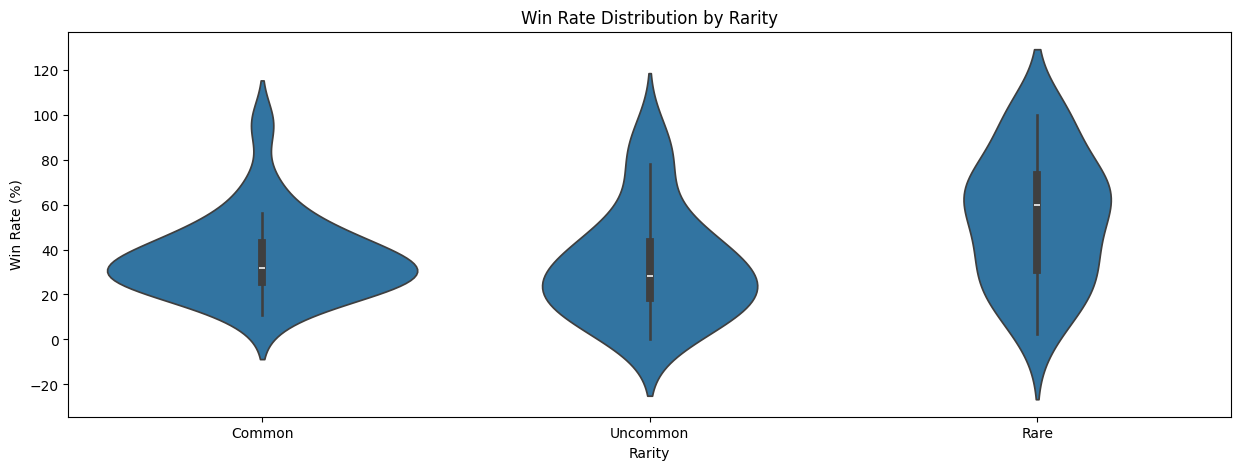

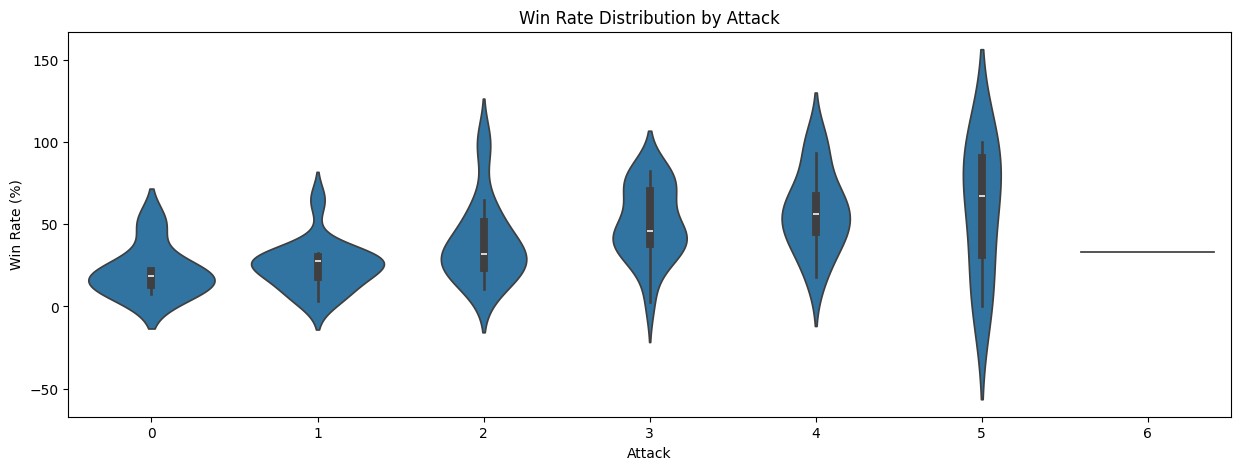

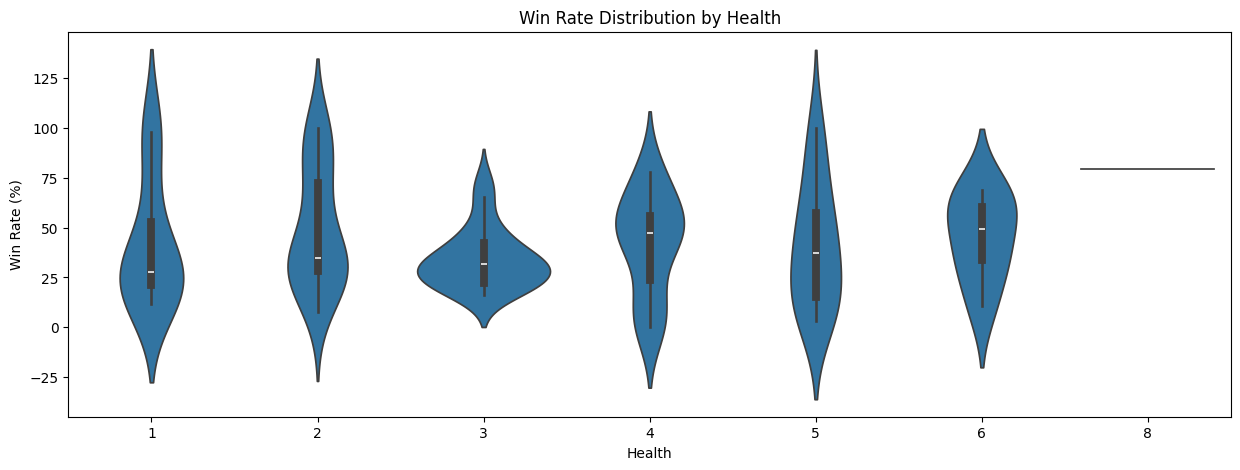

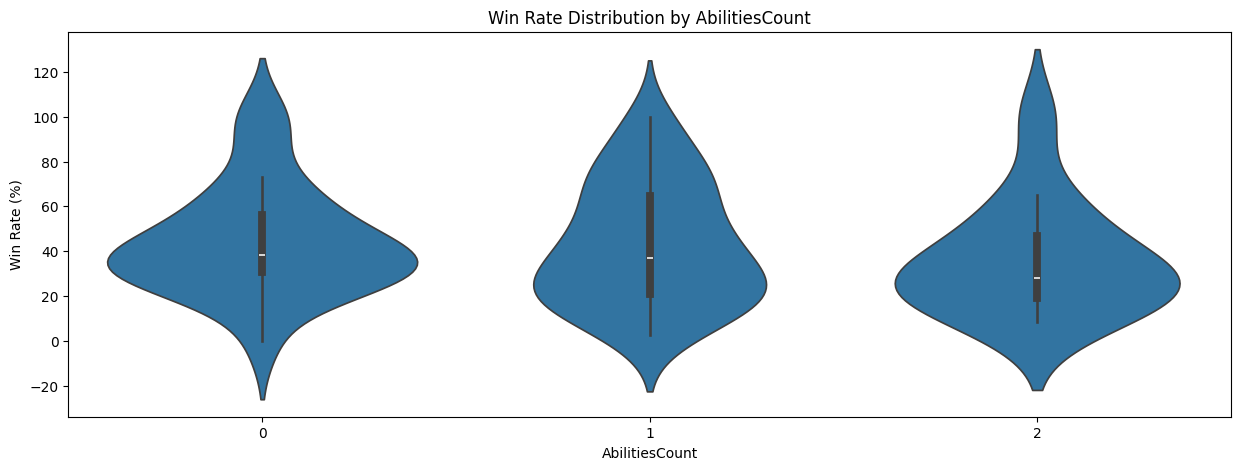

In [6]:
visualize_win_rate_by_factor(df, 'Rarity')
visualize_win_rate_by_factor(df, 'Attack')
visualize_win_rate_by_factor(df, 'Health')
visualize_win_rate_by_factor(df, 'AbilitiesCount')

# AI Cards

Analyzing the win rate impact when the AI plays certain cards

In [7]:
df = pd.read_csv(ENEMY_CARD_RESULTS_PATH, skipinitialspace=True)
df['Abilities'] = df['Abilities'].fillna('None')
df['Win Rate'] = 100.0 * df['Win Count'] / df['Played Count']

top_10_cards = df.sort_values('Win Rate', ascending=False).head(10)
bottom_10_cards = df.sort_values('Win Rate').head(10)

display(HTML('<h2>Top 10 AI Cards by Win Rate</h2>'))
display(HTML(top_10_cards[['Rarity', 'BloodCost', 'Attack', 'Health', 'Abilities', 'Played Count', 'Win Count', 'Lose Count', 'Win Rate']].to_html(index=False)))

display(HTML('<h2>Bottom 10 AI Cards by Win Rate</h2>'))
display(HTML(bottom_10_cards[['Rarity',  'BloodCost', 'Attack', 'Health', 'Abilities', 'Played Count', 'Win Count', 'Lose Count', 'Win Rate']].to_html(index=False)))

Rarity,BloodCost,Attack,Health,Abilities,Played Count,Win Count,Lose Count,Win Rate
Common,Three,5,2,None,69,69,0,100.0
Rare,Three,4,4,Agile,125,125,0,100.0
Rare,Three,2,5,Agile-Lethal,18,18,0,100.0
Rare,One,4,1,None,124,124,0,100.0
Rare,Three,3,8,Guard,8,8,0,100.0
Rare,Three,4,6,Guard,12,12,0,100.0
Uncommon,Three,3,4,Agile,50,50,0,100.0
Rare,Three,5,2,Agile,42,42,0,100.0
Rare,Three,5,4,Guard,110,110,0,100.0
Common,Three,2,5,Lethal,227,227,0,100.0


Rarity,BloodCost,Attack,Health,Abilities,Played Count,Win Count,Lose Count,Win Rate
Uncommon,One,0,3,Guard,5470,3083,2122,56.361974
Uncommon,Two,1,5,Lethal,326,187,139,57.361963
Common,One,0,3,None,9289,5490,3202,59.102164
Rare,Zero,0,3,Guard,1309,797,410,60.886173
Sacrifice,Zero,0,1,None,59865,37233,20835,62.194939
Common,One,0,1,Guard,4044,2552,1371,63.105836
Uncommon,One,0,1,Agile,6030,3950,1816,65.505804
Rare,Zero,0,2,Lethal,5324,3607,1617,67.749812
Rare,Zero,0,1,Agile,3045,2086,898,68.505747
Common,Two,1,1,Agile,6017,4296,1586,71.397706


In [8]:
create_win_rate_grid_by_factor(df, 'Rarity', ['Common', 'Uncommon', 'Rare'])
create_win_rate_grid_by_factor(df, 'BloodCost', ['One', 'Two', 'Three'])
create_win_rate_grid_by_factor(df, 'Abilities', ['None', 'Agile', 'Guard', 'Lethal'])

C:\Users\skyler\AppData\Local\Temp\ipykernel_19784\77429884.py:36: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(factor_win_rate_grid.style.format(str_format).applymap(cell_format))


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,64.54% [10074],73.76% [3243],58.09% [14759],-,76.47% [323],-,-
1,-,73.54% [30532],76.26% [40431],78.20% [6696],89.54% [2180],57.36% [326],-,-
2,-,86.78% [7208],83.87% [831],89.75% [11317],87.37% [3025],87.70% [5758],100.00% [37],-
3,-,86.67% [120],87.83% [961],88.52% [5209],98.38% [1669],100.00% [13],94.23% [849],-
4,-,-,95.93% [344],-,97.88% [1370],-,-,-
5,-,-,100.00% [227],-,100.00% [41],-,-,-


C:\Users\skyler\AppData\Local\Temp\ipykernel_19784\77429884.py:36: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(factor_win_rate_grid.style.format(str_format).applymap(cell_format))


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,65.51% [6030],73.76% [3243],56.36% [5470],-,76.47% [323],-,-
1,-,74.48% [19188],-,77.61% [5927],89.54% [2180],57.36% [326],-,-
2,-,83.06% [2745],83.87% [831],95.59% [2107],84.59% [2239],-,-,-
3,-,-,89.29% [794],96.98% [563],95.96% [421],100.00% [13],-,-
4,-,-,98.61% [144],-,94.92% [59],-,-,-
5,-,-,100.00% [158],-,100.00% [41],-,-,-


C:\Users\skyler\AppData\Local\Temp\ipykernel_19784\77429884.py:36: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(factor_win_rate_grid.style.format(str_format).applymap(cell_format))


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,68.51% [3045],67.75% [5324],60.89% [1309],-,-,-,-
1,-,77.99% [1808],84.30% [5866],83.62% [6525],91.16% [1176],89.16% [1052],-,-
2,-,86.86% [1416],82.57% [1130],93.49% [1629],80.51% [1216],100.00% [53],-,-
3,-,80.85% [564],91.71% [712],95.97% [819],97.17% [247],100.00% [85],100.00% [43],-
4,-,100.00% [124],-,100.00% [28],100.00% [125],99.59% [242],100.00% [12],-
5,-,-,100.00% [42],-,100.00% [110],-,100.00% [71],-


C:\Users\skyler\AppData\Local\Temp\ipykernel_19784\77429884.py:36: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(factor_win_rate_grid.style.format(str_format).applymap(cell_format))


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,64.54% [10074],73.76% [3243],58.09% [14759],-,76.47% [323],-,-
1,-,74.33% [6170],76.53% [41501],78.12% [6976],91.16% [1176],-,-,-
2,-,84.27% [3426],82.57% [1130],88.53% [889],-,-,-,-
3,-,80.85% [564],-,91.62% [179],-,-,-,-
4,-,100.00% [124],-,-,-,-,-,-
5,-,-,-,-,-,-,-,-


C:\Users\skyler\AppData\Local\Temp\ipykernel_19784\77429884.py:36: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(factor_win_rate_grid.style.format(str_format).applymap(cell_format))


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,-,-,-,-,-,-,-
1,-,71.40% [6017],83.78% [4796],85.55% [4866],89.54% [2180],81.64% [1378],-,-
2,-,89.07% [4463],83.87% [831],90.12% [11544],83.15% [3455],87.28% [5566],-,-
3,-,86.67% [120],90.44% [1506],88.11% [4978],96.12% [618],-,-,-
4,-,-,100.00% [117],-,-,-,-,-
5,-,-,-,-,-,-,-,-


C:\Users\skyler\AppData\Local\Temp\ipykernel_19784\77429884.py:36: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(factor_win_rate_grid.style.format(str_format).applymap(cell_format))


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,-,-,-,-,-,-,-
1,-,-,-,-,-,-,-,-
2,-,-,-,95.52% [513],95.29% [786],100.00% [245],100.00% [37],-
3,-,-,80.84% [167],97.24% [871],99.23% [1298],100.00% [98],94.51% [892],-
4,-,-,93.83% [227],100.00% [28],98.06% [1495],99.59% [242],100.00% [12],-
5,-,-,100.00% [269],-,100.00% [151],-,100.00% [71],-


C:\Users\skyler\AppData\Local\Temp\ipykernel_19784\77429884.py:36: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(factor_win_rate_grid.style.format(str_format).applymap(cell_format))


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,62.19% [59865],-,59.10% [9289],-,76.47% [323],-,-
1,-,73.67% [23672],75.25% [35635],75.39% [5779],-,-,-,-
2,-,83.42% [3480],-,84.99% [2685],-,87.20% [5531],-,-
3,-,86.67% [120],-,87.23% [4669],95.42% [371],-,94.23% [849],-
4,-,100.00% [124],100.00% [117],-,98.02% [1311],-,-,-
5,-,-,100.00% [69],-,100.00% [41],-,100.00% [71],-


C:\Users\skyler\AppData\Local\Temp\ipykernel_19784\77429884.py:36: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(factor_win_rate_grid.style.format(str_format).applymap(cell_format))


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,66.51% [9075],-,-,-,-,-,-
1,-,71.40% [6017],-,85.06% [5146],89.54% [2180],-,-,-
2,-,89.13% [681],83.87% [831],100.00% [119],86.31% [2002],100.00% [18],-,-
3,-,-,89.65% [879],95.39% [152],100.00% [50],-,100.00% [43],-
4,-,-,92.59% [27],-,100.00% [125],-,-,-
5,-,-,100.00% [42],-,-,-,-,-


C:\Users\skyler\AppData\Local\Temp\ipykernel_19784\77429884.py:36: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(factor_win_rate_grid.style.format(str_format).applymap(cell_format))


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,63.11% [4044],-,57.24% [6779],-,-,-,-
1,-,80.35% [2651],84.30% [5866],85.28% [2296],-,89.16% [1052],-,-
2,-,89.07% [4463],-,90.56% [8154],84.59% [2239],-,100.00% [37],-
3,-,80.85% [564],89.29% [794],96.98% [563],98.86% [1495],100.00% [85],-,-
4,-,-,94.00% [200],100.00% [28],94.92% [59],-,100.00% [12],-
5,-,-,100.00% [158],-,100.00% [110],-,-,-


C:\Users\skyler\AppData\Local\Temp\ipykernel_19784\77429884.py:36: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(factor_win_rate_grid.style.format(str_format).applymap(cell_format))


Health,0,1,2,3,4,5,6,7
Attack,,,,,,,,
0,-,-,70.02% [8567],-,-,-,-,-
1,-,-,84.06% [10662],86.09% [4097],91.16% [1176],81.64% [1378],-,-
2,-,-,82.57% [1130],96.30% [3241],-,100.00% [280],-,-
3,-,-,-,97.42% [1359],-,100.00% [98],-,-
4,-,-,-,100.00% [28],-,99.59% [242],-,-
5,-,-,-,-,-,-,-,-


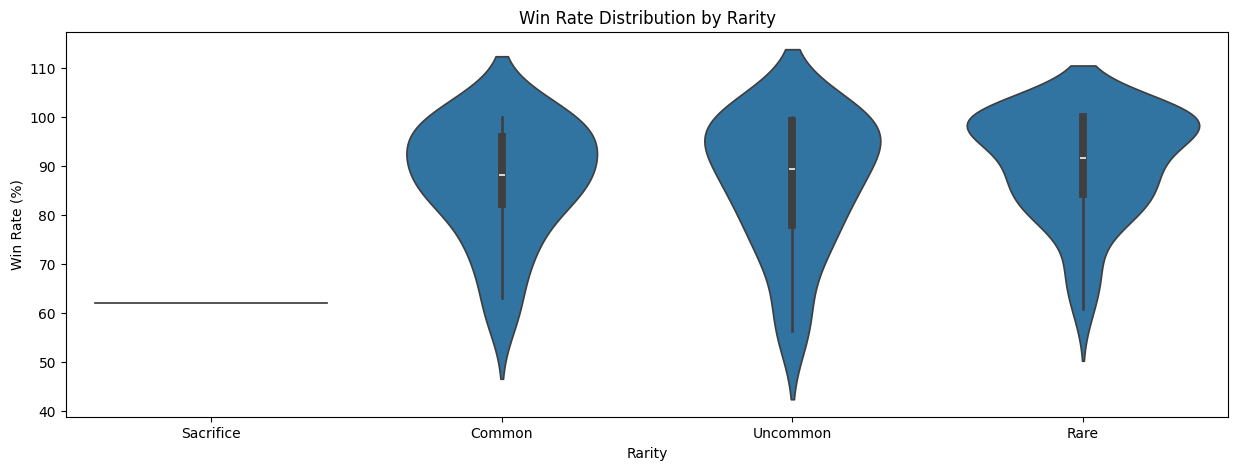

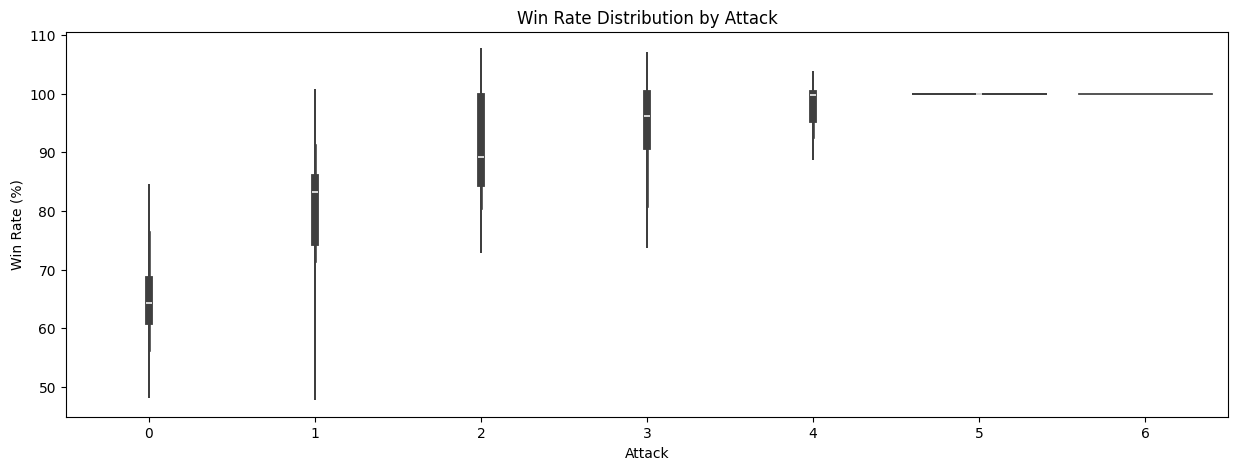

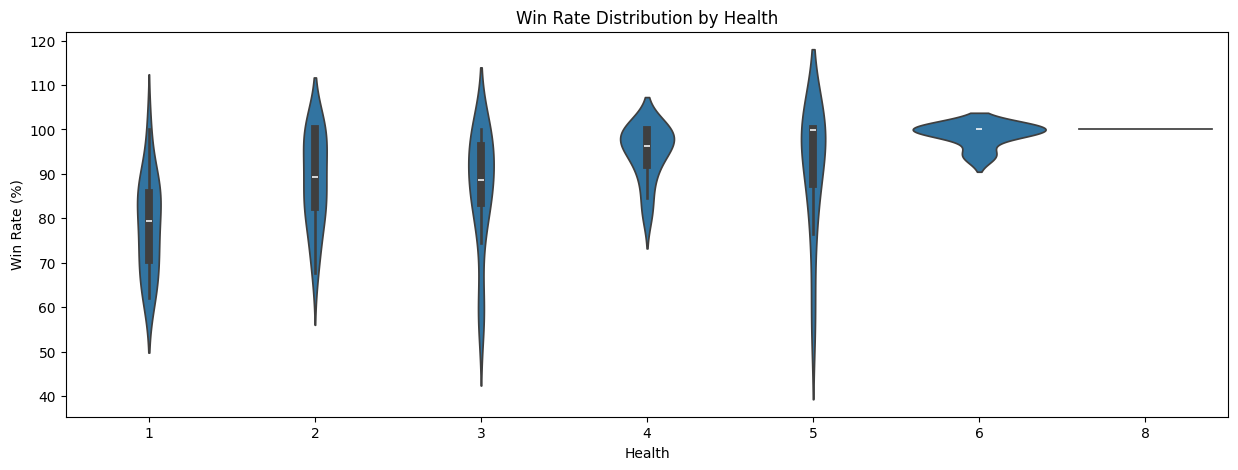

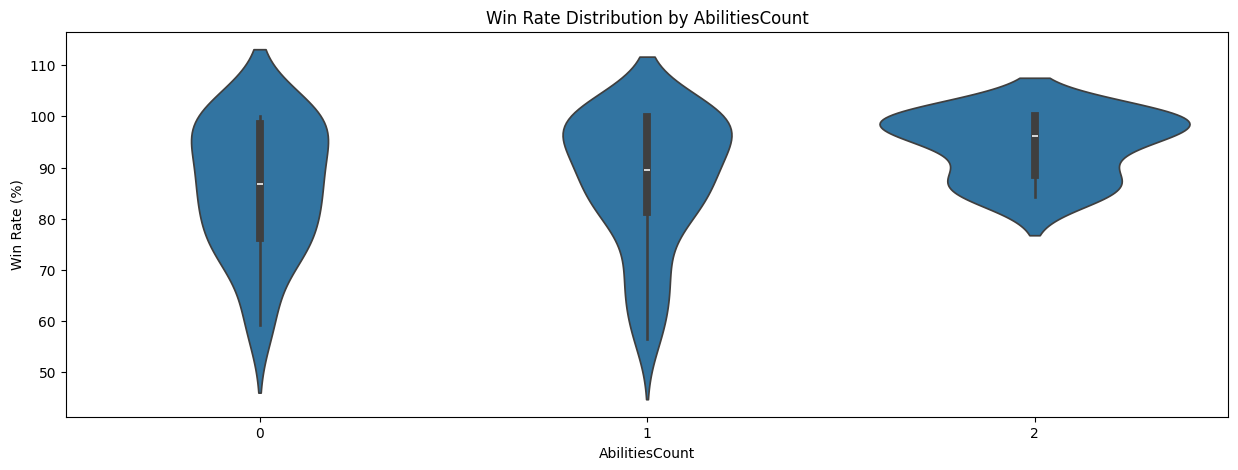

In [9]:
mean_win_rate = df['Win Count'].sum() / df['Played Count'].sum()
display(HTML(f'<h2>Median Win Rate: {mean_win_rate:.2f}%</h2>'))

visualize_win_rate_by_factor(df, 'Rarity')
visualize_win_rate_by_factor(df, 'Attack')
visualize_win_rate_by_factor(df, 'Health')
visualize_win_rate_by_factor(df, 'AbilitiesCount')